In [193]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import cv2

In [194]:
latent_dim = 100

generator = tf.keras.Sequential([
    layers.Dense(7 * 7 * 256, input_shape=(latent_dim,)),
    layers.Reshape((7, 7, 256)),
    layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='sigmoid')
])


In [195]:
discriminator = tf.keras.Sequential([
    layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]),
    layers.LeakyReLU(alpha=0.2),
    layers.Dropout(0.3),
    layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
    layers.LeakyReLU(alpha=0.2),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(1)
])

In [196]:
# Define loss functions and optimizers
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [197]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [198]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


In [199]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [200]:
# Compile the models
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, latent_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [201]:
def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch in dataset:
            train_step(image_batch)

In [202]:
# Load the dog images
image_dir = 'dog'
image_files = [os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith('.jpg')]
images = []

for image_file in image_files:
    image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (28, 28))
    image = image / 255.0  # Normalize the images to [0, 1]
    image = np.expand_dims(image, axis=-1)  # Add channel dimension
    images.append(image)

In [203]:
# image = tf.image.resize(image, [100, 100])


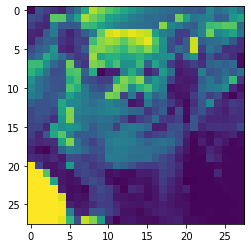

In [204]:
import matplotlib.pyplot as plt
plt.imshow(images[0])

In [205]:
images[0].shape

(28, 28, 1)

In [206]:
images = np.array(images)

# Create a TensorFlow dataset
BATCH_SIZE = 128
BUFFER_SIZE = 1000
dataset = tf.data.Dataset.from_tensor_slices(images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [207]:
# Train the GAN model
EPOCHS = 50
train(dataset, EPOCHS)

In [208]:
# Generate new dog images
num_images = 50
random_latent_vectors = tf.random.normal(shape=(num_images, latent_dim))
generated_images = generator(random_latent_vectors, training=False)

In [209]:
output_dir = 'generated_image'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    

In [210]:
for i in range(num_images):
    generated_image = generated_images[i].numpy()
    generated_image = (generated_image * 127.5 + 127.5).astype(np.uint8)
    image_path = os.path.join(output_dir, f'generated_image_{i+1}.jpg')
    tf.io.write_file(image_path, tf.image.encode_jpeg(generated_image))

In [211]:
#open image using path
from IPython.display import Image
Image(filename='generated_image/generated_image_1.jpg')
# shape of the image
generated_image.shape


(28, 28, 1)